# Benchmark aggregation by hardware

This notebook loads a benchmark CSV (same format as the project outputs) and builds
per-hardware dataframes that include IDLE rows and the mean across repeats for each run.


In [1]:
from pathlib import Path
import pandas as pd

# Update this path if needed
csv_path = Path("all_benchmark_results.csv")
if not csv_path.exists():
    csv_path = Path("..") / csv_path

csv_path

PosixPath('../all_benchmark_results.csv')

In [2]:
df = pd.read_csv(csv_path)
df.head()

,Timestamp,Phase,Hardware,Model_Name,Size_MB,ImgSz,E2E_Time_ms,Device_Time_ms,mAP50,Precision,...,MATCH_IOU,MAX_DET,WARMUP,ultralytics,depthai,opencv,torch,cuda,tensorrt,onnxruntime
0,"2026-01-15T14:08:28,739",idle,GPU_ORT_CUDA_ALL,IDLE,0.00,0,0.00,0.00,0.00,0.0000,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2
1,"2026-01-15T14:08:31,374",run,GPU_ORT_CUDA_ALL,yolo11m_640_fp32,76.89,640,12.93,10.01,0.78,0.7906,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2
2,"2026-01-15T14:08:33,976",run,GPU_ORT_CUDA_ALL,yolo11m_640_fp32,76.89,640,12.59,9.90,0.78,0.7906,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2
3,"2026-01-15T14:08:36,595",run,GPU_ORT_CUDA_ALL,yolo11m_640_fp32,76.89,640,12.61,9.91,0.78,0.7906,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2
4,"2026-01-15T14:08:39,200",run,GPU_ORT_CUDA_BASIC,yolo11m_640_fp32,76.89,640,14.66,11.74,0.78,0.7906,...,0.5,300,10,8.3.241,2.28.0.0,4.11.0,2.9.1+cu128,12.8,NaN,1.23.2


In [3]:
def aggregate_by_hardware(df_in: pd.DataFrame, hardware_prefix: str) -> pd.DataFrame:
    hw_df = df_in[df_in["Hardware"].str.startswith(hardware_prefix, na=False)].copy()
    if hw_df.empty:
        return pd.DataFrame()

    # Convert numeric columns
    for col in hw_df.columns:
        if col in {"Timestamp", "Phase", "Hardware", "Model_Name", "Dataset", "Backend",
                   "ORT_Level_Requested", "Providers_Used"}:
            continue
        hw_df[col] = pd.to_numeric(hw_df[col], errors="coerce")

    id_cols = [c for c in hw_df.columns if c != "Timestamp" and not pd.api.types.is_numeric_dtype(hw_df[c])]
    num_cols = [c for c in hw_df.columns if c not in id_cols + ["Timestamp"]]

    agg = (
        hw_df
        .groupby(id_cols, dropna=False)[num_cols]
        .mean(numeric_only=True)
        .reset_index()
    )

    # Keep idle first, then run rows ordered by model name
    if "Phase" in agg.columns and "Model_Name" in agg.columns:
        agg = agg.sort_values(["Phase", "Model_Name"], ascending=[True, True])

    return agg


df_gpu = aggregate_by_hardware(df, "GPU_")
df_cpu_pc = aggregate_by_hardware(df, "CPU_ORT_PC")
df_cpu_pi = aggregate_by_hardware(df, "CPU_ORT_PI4")
df_oak = aggregate_by_hardware(df, "OAK_")


dfs = {
    "gpu": df_gpu,
    "cpu_pc": df_cpu_pc,
    "cpu_pi": df_cpu_pi,
    "oak": df_oak,
}

for name, d in dfs.items():
    if d is None or d.empty:
        continue
    print(f"{name}: {len(d)} rows")
    display(d.head())


gpu: 91 rows


,Phase,Hardware,Model_Name,ORT_Level_Requested,Providers_Used,Dataset,Backend,Size_MB,ImgSz,E2E_Time_ms,...,MATCH_IOU,MAX_DET,WARMUP,ultralytics,depthai,opencv,torch,cuda,tensorrt,onnxruntime
0,idle,GPU_ORT_CUDA_ALL,IDLE,all->all,"CUDAExecutionProvider,CPUExecutionProvider",coco128,onnxruntime,0.00,0.0,0.000000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN
1,run,GPU_ORT_CUDA_ALL,yolo11m_256_fp16,all->all,"CUDAExecutionProvider,CPUExecutionProvider",coco128,onnxruntime,38.42,256.0,4.550000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN
31,run,GPU_ORT_CUDA_BASIC,yolo11m_256_fp16,basic->basic,"CUDAExecutionProvider,CPUExecutionProvider",coco128,onnxruntime,38.42,256.0,4.673333,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN
61,run,GPU_ORT_CUDA_DISABLE,yolo11m_256_fp16,disable->disable,"CUDAExecutionProvider,CPUExecutionProvider",coco128,onnxruntime,38.42,256.0,4.853333,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN
2,run,GPU_ORT_CUDA_ALL,yolo11m_256_fp32,all->all,"CUDAExecutionProvider,CPUExecutionProvider",coco128,onnxruntime,76.75,256.0,4.563333,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN


cpu_pc: 91 rows


,Phase,Hardware,Model_Name,ORT_Level_Requested,Providers_Used,Dataset,Backend,Size_MB,ImgSz,E2E_Time_ms,...,MATCH_IOU,MAX_DET,WARMUP,ultralytics,depthai,opencv,torch,cuda,tensorrt,onnxruntime
0,idle,CPU_ORT_PC_x86_64_SEQ_ALL,IDLE,all->all,CPUExecutionProvider,coco128,onnxruntime-cpu,0.00,0.0,0.000000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN
1,run,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11m_256_fp16,"ALL_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,38.42,256.0,26.906667,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN
31,run,CPU_ORT_PC_x86_64_SEQ_BASIC,yolo11m_256_fp16,"BASIC_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,38.42,256.0,43.200000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN
61,run,CPU_ORT_PC_x86_64_SEQ_DISABLE,yolo11m_256_fp16,"DISABLE_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,38.42,256.0,43.600000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN
2,run,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11m_256_fp32,"ALL_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,76.75,256.0,25.920000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,12.8,NaN,NaN


cpu_pi: 31 rows


,Phase,Hardware,Model_Name,ORT_Level_Requested,Providers_Used,Dataset,Backend,Size_MB,ImgSz,E2E_Time_ms,...,MATCH_IOU,MAX_DET,WARMUP,ultralytics,depthai,opencv,torch,cuda,tensorrt,onnxruntime
0,idle,CPU_ORT_PI4_SEQ_ALL,IDLE,all->all,CPUExecutionProvider,coco128,onnxruntime-cpu,0.00,0.0,0.000000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,run,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp16,"ALL_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,5.07,256.0,105.676667,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,run,CPU_ORT_PI4_SEQ_BASIC,yolo11n_256_fp16,"BASIC_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,5.07,256.0,122.890000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,run,CPU_ORT_PI4_SEQ_DISABLE,yolo11n_256_fp16,"DISABLE_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,5.07,256.0,122.850000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,run,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp32,"ALL_SEQ_intra=auto,inter=1",CPUExecutionProvider,coco128,onnxruntime-cpu,10.07,256.0,101.733333,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


oak: 76 rows


,Phase,Hardware,Model_Name,ORT_Level_Requested,Providers_Used,Dataset,Backend,Size_MB,ImgSz,E2E_Time_ms,...,MATCH_IOU,MAX_DET,WARMUP,ultralytics,depthai,opencv,torch,cuda,tensorrt,onnxruntime
0,idle,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_4,IDLE,NaN,NaN,coco128,depthai,0.00,0.0,0.000000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,run,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_4,yolo11m_256_fp16_4shave,NaN,NaN,coco128,depthai,39.75,256.0,144.530000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,run,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_5,yolo11m_256_fp16_5shave,NaN,NaN,coco128,depthai,39.74,256.0,148.780000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,run,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11m_256_fp16_6shave,NaN,NaN,coco128,depthai,39.74,256.0,143.000000,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,run,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_7,yolo11m_256_fp16_7shave,NaN,NaN,coco128,depthai,39.74,256.0,142.803333,...,0.5,300.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Quick sanity checks
print("GPU rows:", len(df_gpu))
print("CPU rows:", len(df_cpu_pc))

print("GPU idle rows:", (df_gpu["Phase"] == "idle").sum() if not df_gpu.empty else 0)
print("CPU idle rows:", (df_cpu_pc["Phase"] == "idle").sum() if not df_cpu_pc.empty else 0)

GPU rows: 91
CPU rows: 91
GPU idle rows: 1
CPU idle rows: 1


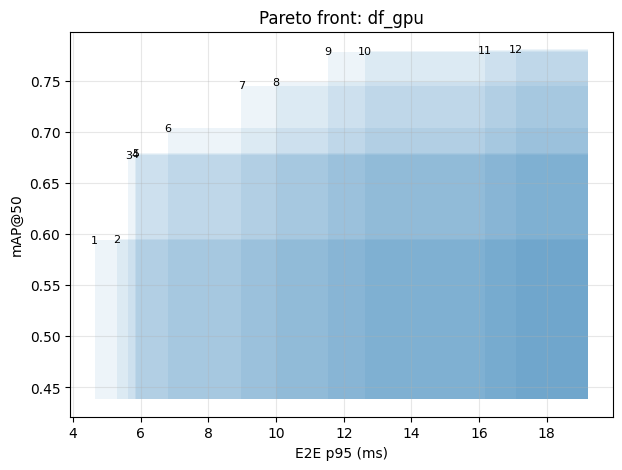

,Pareto_id,Label,mAP50,Latency_p95,Size_MB,Power_W_Mean,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
0,1,s 256 fp32 ORT ALL,0.5942,4.636667,36.12,117.666667,1866.750000,11062.200000,358.333333
1,2,s 256 fp16 ORT ALL,0.5953,5.296667,18.09,102.333333,1866.750000,10991.546667,283.000000
2,3,m 256 fp16 ORT ALL,0.6770,5.630000,38.42,114.000000,1856.300000,10683.690000,356.333333
3,4,m 256 fp32 ORT DISABLE,0.6785,5.836667,76.75,150.333333,1845.473333,10740.473333,483.000000
4,5,m 256 fp16 ORT BASIC,0.6793,5.863333,38.42,118.333333,1856.310000,10691.936667,357.666667
5,6,m 320 fp32 ORT ALL,0.7034,6.800000,76.77,109.333333,1871.490000,10751.306667,484.333333
6,7,m 416 fp32 ORT ALL,0.7452,8.973333,76.79,134.666667,1843.270000,10674.106667,486.333333
7,8,m 416 fp16 ORT ALL,0.7487,10.003333,38.44,122.666667,1853.580000,10727.436667,356.333333
8,9,m 512 fp32 ORT ALL,0.7783,11.530000,76.83,139.000000,1838.390000,10605.546667,741.666667
9,10,m 512 fp16 ORT ALL,0.7788,12.616667,38.46,127.333333,1842.440000,10652.756667,483.666667


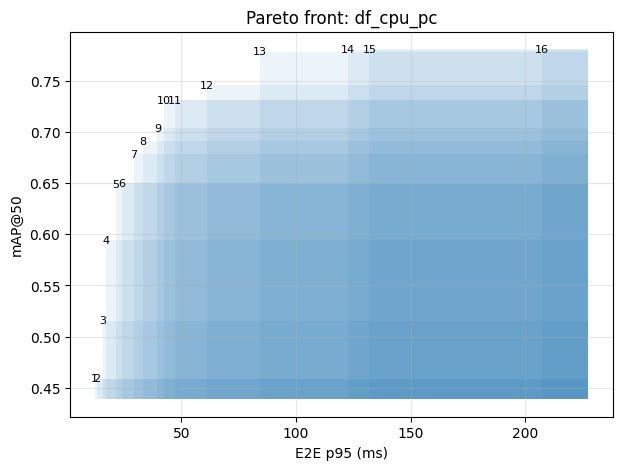

,Pareto_id,Label,mAP50,Latency_p95,Size_MB,Power_W_Mean,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
0,1,n 256 fp32 ORT ALL,0.4589,12.236667,10.07,97.333333,866.000000,12459.790000,NaN
1,2,n 256 fp16 ORT ALL,0.4590,13.156667,5.07,96.666667,866.000000,12397.683333,NaN
2,3,n 320 fp16 ORT ALL,0.5154,15.896667,5.08,97.666667,866.260000,12490.683333,NaN
3,4,s 256 fp32 ORT ALL,0.5943,17.133333,36.12,98.333333,884.566667,11820.610000,NaN
4,5,s 320 fp32 ORT ALL,0.6486,21.516667,36.13,99.000000,888.610000,11749.860000,NaN
5,6,s 320 fp16 ORT ALL,0.6499,24.006667,18.10,98.000000,891.053333,11827.093333,NaN
6,7,m 256 fp32 ORT ALL,0.6783,29.333333,76.75,98.333333,981.243333,11451.163333,NaN
7,8,s 416 fp32 ORT ALL,0.6911,33.313333,36.16,99.333333,925.980000,11672.466667,NaN
8,9,m 320 fp32 ORT ALL,0.7034,39.613333,76.77,98.556667,996.603333,11177.236667,NaN
9,10,s 512 fp32 ORT ALL,0.7307,42.320000,36.19,99.003333,937.880000,11445.713333,NaN


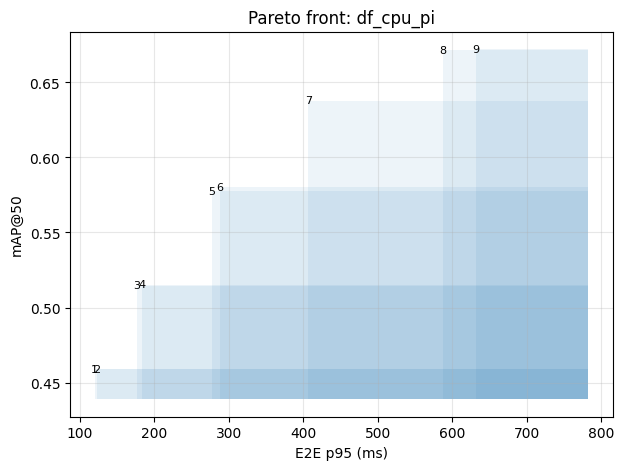

,Pareto_id,Label,mAP50,Latency_p95,Size_MB,Power_W_Mean,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
0,1,n 256 fp32 ORT ALL,0.4589,119.993333,10.07,5.816667,375.430000,559.293333,NaN
1,2,n 256 fp16 ORT ALL,0.4590,122.586667,5.07,5.750000,375.430000,556.080000,NaN
2,3,n 320 fp32 ORT ALL,0.5145,176.473333,10.09,5.820000,375.430000,554.930000,NaN
3,4,n 320 fp16 ORT ALL,0.5153,182.903333,5.08,5.760000,375.430000,554.540000,NaN
4,5,n 416 fp32 ORT ALL,0.5776,277.390000,10.11,5.880000,375.420000,559.723333,NaN
5,6,n 416 fp16 ORT ALL,0.5801,288.016667,5.09,5.590000,375.420000,555.616667,NaN
6,7,n 512 fp32 ORT ALL,0.6377,406.806667,10.15,5.893333,393.816667,573.536667,NaN
7,8,n 640 fp32 ORT ALL,0.6716,587.560000,10.21,5.553333,511.246667,569.143333,NaN
8,9,n 640 fp16 ORT ALL,0.6721,631.633333,5.14,5.340000,540.113333,604.040000,NaN


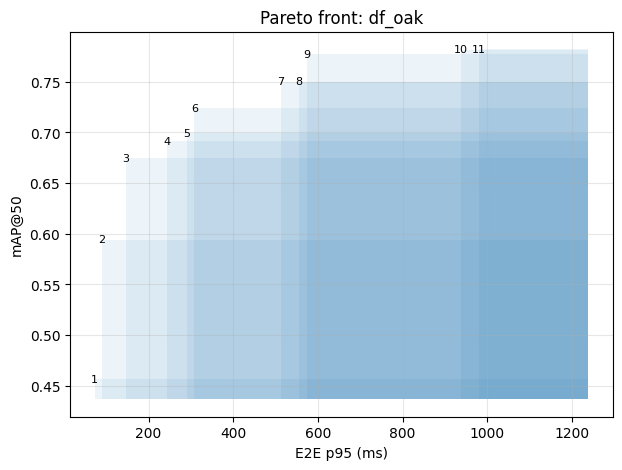

,Pareto_id,Label,mAP50,Latency_p95,Size_MB,Power_W_Mean,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
0,1,n 256 fp16 OAK S6,0.4567,72.616667,5.54,5.866667,386.276667,559.640000,NaN
1,2,s 256 fp16 OAK S4,0.5942,89.753333,18.96,6.390000,325.660000,517.320000,NaN
2,3,m 256 fp16 OAK S8,0.6745,147.033333,39.73,6.666667,481.663333,545.836667,NaN
3,4,s 416 fp16 OAK S6,0.6914,243.863333,19.04,6.760000,282.503333,485.853333,NaN
4,5,m 320 fp16 OAK S7,0.6995,290.450000,39.89,6.943333,487.806667,551.633333,NaN
5,6,s 512 fp16 OAK S7,0.7238,308.203333,19.03,6.800000,285.060000,486.516667,NaN
6,7,m 416 fp16 OAK S8,0.7501,512.180000,40.05,6.960000,497.140000,563.316667,NaN
7,8,m 416 fp16 OAK S5,0.7503,555.193333,40.11,6.930000,494.676667,560.196667,NaN
8,9,m 512 fp16 OAK S8,0.7774,574.106667,39.86,6.950000,515.530000,585.216667,NaN
9,10,m 640 fp16 OAK S8,0.7816,937.793333,40.27,6.936667,442.290000,613.740000,NaN


In [5]:
import re
import numpy as np
import matplotlib.pyplot as plt

def pareto_min_max(df: pd.DataFrame, min_col: str, max_col: str) -> pd.DataFrame:
    work = df.copy()
    work = work[(work["Phase"] == "run") & work[min_col].notna() & work[max_col].notna()]
    if work.empty:
        return work

    vals = work[[min_col, max_col]].values
    is_pareto = np.ones(len(work), dtype=bool)

    for i, (x, y) in enumerate(vals):
        if not is_pareto[i]:
            continue
        dominated = (vals[:, 0] <= x) & (vals[:, 1] >= y) & (
            (vals[:, 0] < x) | (vals[:, 1] > y)
        )
        if dominated.any():
            is_pareto[i] = False

    return work[is_pareto].sort_values([min_col, max_col], ascending=[True, False])


def short_label(row: pd.Series) -> str:
    name = str(row.get("Model_Name", ""))
    match = re.search(r"yolo11([nsm])_(\d+)_(fp16|fp32|int8)", name)
    if match:
        scale, imgsz, quant = match.groups()
        base = f"{scale} {imgsz} {quant}"
    else:
        base = name

    hardware = str(row.get("Hardware", ""))
    backend = ""
    opt = ""

    if "ORT" in hardware:
        backend = "ORT"
        m2 = re.search(r"_(ALL|BASIC|DISABLE)\b", hardware)
        if m2:
            opt = m2.group(1)
        else:
            ort = str(row.get("ORT_Level_Requested", ""))
            if ort and ort != "N/A":
                opt = ort.split("->")[-1]
    elif "TRT" in hardware:
        backend = "TRT"
        m2 = re.search(r"_H(\d+)_SP(\d+)", hardware)
        if m2:
            opt = f"H{m2.group(1)}SP{m2.group(2)}"
    elif hardware.startswith("OAK"):
        backend = "OAK"
        m2 = re.search(r"_SHAVES_(\d+)", hardware)
        if m2:
            opt = f"S{m2.group(1)}"
    else:
        backend = str(row.get("Backend", "" )).upper()

    if backend:
        return f"{base} {backend} {opt}".strip()
    return base


all_dfs = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Latency_p95", "mAP50"}.issubset(val.columns)
}

pareto_dfs = {
    name: pareto_min_max(val, "Latency_p95", "mAP50")
    for name, val in all_dfs.items()
}

for name, pdf in pareto_dfs.items():
    if pdf.empty:
        print(f"{name}: no rows")
        continue

    pdf = pdf.reset_index(drop=True)
    pdf["Pareto_id"] = np.arange(1, len(pdf) + 1)
    pdf["Label"] = pdf.apply(short_label, axis=1)

    # Reference point for hypervolume shading (worse corner)
    work = all_dfs[name]
    work = work[(work["Phase"] == "run") & work["Latency_p95"].notna() & work["mAP50"].notna()]
    ref_x = work["Latency_p95"].max() * 1.05
    ref_y = max(0.0, work["mAP50"].min() - 0.02)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Hypervolume (dominated region) shading
    for _, row in pdf.iterrows():
        ax.fill_between(
            [row["Latency_p95"], ref_x],
            ref_y,
            row["mAP50"],
            color="tab:blue",
            alpha=0.08,
            linewidth=0,
        )

    # Points + numeric labels
    for _, row in pdf.iterrows():
        ax.text(
            row["Latency_p95"],
            row["mAP50"],
            str(int(row["Pareto_id"])),
            fontsize=8,
            ha="center",
            va="center",
        )
    ax.set_xlabel("E2E p95 (ms)")
    ax.set_ylabel("mAP@50")
    ax.set_title(f"Pareto front: {name}")
    ax.grid(True, alpha=0.3)
    plt.show()

    # Mapping table
    pareto_cols = [
        "Pareto_id",
        "Label",
        "mAP50",
        "Latency_p95",
        "Size_MB",
        "Power_W_Mean",
        "RAM_RSS_MB_Mean",
        "RAM_Sys_Used_MB_Mean",
        "VRAM_Used_MB_Mean",
    ]
    display(pdf[[c for c in pareto_cols if c in pdf.columns]])


In [6]:
# Top-3 tables per objective
import numpy as np

def build_top_tables(df_in: pd.DataFrame, name: str) -> None:
    if df_in.empty:
        print(f"{name}: empty dataframe")
        return

    work = df_in.copy()
    for col in work.columns:
        if col in {"Timestamp", "Phase", "Hardware", "Model_Name", "Dataset", "Backend",
                   "ORT_Level_Requested", "Providers_Used"}:
            continue
        work[col] = pd.to_numeric(work[col], errors="coerce")

    power_col = "Power_W_Mean" if "Power_W_Mean" in work.columns else None

    delta_cols = []
    if power_col:
        delta_cols.append(power_col)
    for c in ["RAM_RSS_MB_Mean", "RAM_Sys_Used_MB_Mean", "VRAM_Used_MB_Mean"]:
        if c in work.columns:
            delta_cols.append(c)

    if delta_cols and "Phase" in work.columns and "Hardware" in work.columns:
        idle = work[work["Phase"] == "idle"]
        if not idle.empty:
            base_by_hw = (
                idle.groupby("Hardware")[delta_cols]
                .mean(numeric_only=True)
                .add_prefix("idle_")
            )
            base_all = idle[delta_cols].mean(numeric_only=True)
            work = work.merge(base_by_hw, left_on="Hardware", right_index=True, how="left")
            for c in delta_cols:
                idle_col = f"idle_{c}"
                if idle_col not in work.columns:
                    work[idle_col] = np.nan
                if c in base_all.index:
                    work[idle_col] = work[idle_col].fillna(base_all[c])
                work[f"{c}_delta"] = work[c] - work[idle_col]

    use_cols = ["Hardware", "Model_Name", "Latency_p95", "mAP50", "Size_MB"]
    if "Pareto_id" in work.columns:
        use_cols.append("Pareto_id")
    if power_col:
        use_cols.append(f"{power_col}_delta")
    if "RAM_RSS_MB_Mean_delta" in work.columns:
        use_cols.append("RAM_RSS_MB_Mean_delta")
    if "RAM_Sys_Used_MB_Mean_delta" in work.columns:
        use_cols.append("RAM_Sys_Used_MB_Mean_delta")
    if "VRAM_Used_MB_Mean_delta" in work.columns:
        use_cols.append("VRAM_Used_MB_Mean_delta")

    run = work[work["Phase"] == "run"].copy()
    if run.empty:
        print(f"{name}: no run rows")
        return

    obj1 = run.sort_values(["mAP50", "Latency_p95"], ascending=[False, True]).head(3)
    obj2 = run.sort_values(["Latency_p95", "mAP50"], ascending=[True, False]).head(3)

    print(f"{name} - objectif 1 (mAP50 desc, p95 asc)")
    display(obj1[use_cols])
    print(f"{name} - objectif 2 (p95 asc, mAP50 desc)")
    display(obj2[use_cols])


dfs_for_tables = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Latency_p95", "mAP50"}.issubset(val.columns)
}

for name, df in dfs_for_tables.items():
    build_top_tables(df, name)


df_gpu - objectif 1 (mAP50 desc, p95 asc)


,Hardware,Model_Name,Latency_p95,mAP50,Size_MB,Power_W_Mean_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
9,GPU_ORT_CUDA_ALL,yolo11m_640_fp16,17.086667,0.7809,38.48,44.000000,1002.816667,965.130000,146.0
39,GPU_ORT_CUDA_BASIC,yolo11m_640_fp16,18.003333,0.7805,38.48,55.666667,1011.640000,1033.523333,146.0
69,GPU_ORT_CUDA_DISABLE,yolo11m_640_fp16,18.300000,0.7805,38.48,56.000000,1012.996667,998.983333,146.0


df_gpu - objectif 2 (p95 asc, mAP50 desc)


,Hardware,Model_Name,Latency_p95,mAP50,Size_MB,Power_W_Mean_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
22,GPU_ORT_CUDA_ALL,yolo11s_256_fp32,4.636667,0.5942,36.12,40.666667,1056.04,1498.060000,21.333333
52,GPU_ORT_CUDA_BASIC,yolo11s_256_fp32,4.686667,0.5942,36.12,65.333333,1056.04,1474.056667,20.666667
82,GPU_ORT_CUDA_DISABLE,yolo11s_256_fp32,4.803333,0.5942,36.12,65.666667,1056.04,1460.900000,20.000000


df_cpu_pc - objectif 1 (mAP50 desc, p95 asc)


,Hardware,Model_Name,Latency_p95,mAP50,Size_MB,Power_W_Mean_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
39,CPU_ORT_PC_x86_64_SEQ_BASIC,yolo11m_640_fp16,207.373333,0.7806,38.48,64.526667,430.006667,-192.683333,NaN
69,CPU_ORT_PC_x86_64_SEQ_DISABLE,yolo11m_640_fp16,216.426667,0.7806,38.48,65.143333,430.120000,-36.223333,NaN
9,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11m_640_fp16,132.013333,0.7805,38.48,65.166667,489.746667,-168.620000,NaN


df_cpu_pc - objectif 2 (p95 asc, mAP50 desc)


,Hardware,Model_Name,Latency_p95,mAP50,Size_MB,Power_W_Mean_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
12,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11n_256_fp32,12.236667,0.4589,10.07,62.833333,88.39,1498.090000,NaN
72,CPU_ORT_PC_x86_64_SEQ_DISABLE,yolo11n_256_fp32,12.843333,0.4589,10.07,62.833333,89.58,1520.313333,NaN
11,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11n_256_fp16,13.156667,0.4590,5.07,62.166667,88.39,1435.983333,NaN


df_cpu_pi - objectif 1 (mAP50 desc, p95 asc)


,Hardware,Model_Name,Latency_p95,mAP50,Size_MB,Power_W_Mean_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
9,CPU_ORT_PI4_SEQ_ALL,yolo11n_640_fp16,631.633333,0.6721,5.14,2.340000,247.323333,226.020000,NaN
29,CPU_ORT_PI4_SEQ_DISABLE,yolo11n_640_fp16,639.243333,0.6721,5.14,2.296667,138.506667,236.683333,NaN
19,CPU_ORT_PI4_SEQ_BASIC,yolo11n_640_fp16,745.086667,0.6721,5.14,2.306667,220.983333,241.820000,NaN


df_cpu_pi - objectif 2 (p95 asc, mAP50 desc)


,Hardware,Model_Name,Latency_p95,mAP50,Size_MB,Power_W_Mean_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
2,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp32,119.993333,0.4589,10.07,2.816667,82.64,181.273333,NaN
1,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp16,122.586667,0.4590,5.07,2.750000,82.64,178.060000,NaN
22,CPU_ORT_PI4_SEQ_DISABLE,yolo11n_256_fp32,127.733333,0.4589,10.07,2.793333,82.64,181.400000,NaN


df_oak - objectif 1 (mAP50 desc, p95 asc)


,Hardware,Model_Name,Latency_p95,mAP50,Size_MB,Power_W_Mean_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
50,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_7,yolo11m_640_fp16_7shave,980.953333,0.7822,40.32,1.943333,45.390000,94.256667,NaN
35,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11m_640_fp16_6shave,1010.526667,0.7818,40.31,1.893333,84.643333,94.373333,NaN
65,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_8,yolo11m_640_fp16_8shave,937.793333,0.7816,40.27,1.936667,5.890000,96.090000,NaN


df_oak - objectif 2 (p95 asc, mAP50 desc)


,Hardware,Model_Name,Latency_p95,mAP50,Size_MB,Power_W_Mean_delta,RAM_RSS_MB_Mean_delta,RAM_Sys_Used_MB_Mean_delta,VRAM_Used_MB_Mean_delta
36,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11n_256_fp16_6shave,72.616667,0.4567,5.54,0.866667,-50.123333,41.990000,NaN
6,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_4,yolo11n_256_fp16_4shave,72.666667,0.4567,5.54,1.066667,-49.330000,41.030000,NaN
51,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_7,yolo11n_256_fp16_7shave,72.766667,0.4567,5.54,1.066667,-50.323333,43.756667,NaN


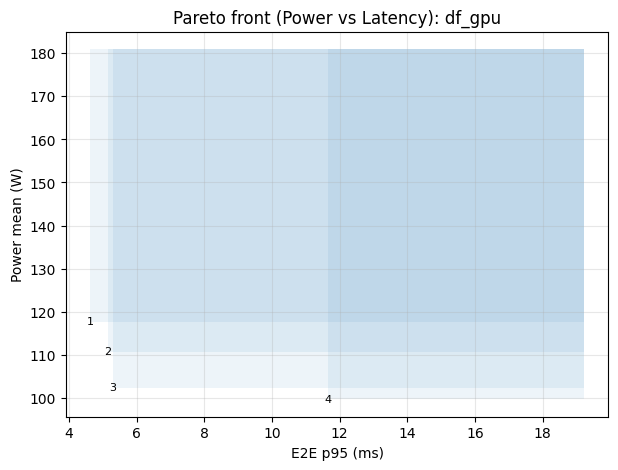

,Pareto_id_power,Label,mAP50,Latency_p95,Size_MB,Power_W_Mean,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
0,1,s 256 fp32 ORT ALL,0.5942,4.636667,36.12,117.666667,1866.75,11062.200000,358.333333
1,2,n 256 fp32 ORT BASIC,0.4589,5.143333,10.07,110.666667,1867.53,12049.170000,261.000000
2,3,s 256 fp16 ORT ALL,0.5953,5.296667,18.09,102.333333,1866.75,10991.546667,283.000000
3,4,s 512 fp16 ORT BASIC,0.7311,11.653333,18.13,99.666667,1867.50,11093.253333,357.666667


df_gpu - objectif 1 (power mean asc, p95 asc)


,Hardware,Model_Name,Latency_p95,Power_W_Mean,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
79,GPU_ORT_CUDA_BASIC,yolo11s_512_fp16,11.653333,99.666667,0.7311,18.13,4.0,1867.50,11093.253333,357.666667
60,GPU_ORT_CUDA_ALL,yolo11s_256_fp16,5.296667,102.333333,0.5953,18.09,3.0,1866.75,10991.546667,283.000000
38,GPU_ORT_CUDA_DISABLE,yolo11n_320_fp16,6.840000,105.333333,0.5162,5.08,NaN,1867.53,12008.540000,261.000000


df_gpu - objectif 2 (p95 asc, power mean asc)


,Hardware,Model_Name,Latency_p95,Power_W_Mean,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
63,GPU_ORT_CUDA_ALL,yolo11s_256_fp32,4.636667,117.666667,0.5942,36.12,1.0,1866.75,11062.200000,358.333333
64,GPU_ORT_CUDA_BASIC,yolo11s_256_fp32,4.686667,142.333333,0.5942,36.12,NaN,1866.75,11038.196667,357.666667
65,GPU_ORT_CUDA_DISABLE,yolo11s_256_fp32,4.803333,142.666667,0.5942,36.12,NaN,1866.75,11025.040000,357.000000


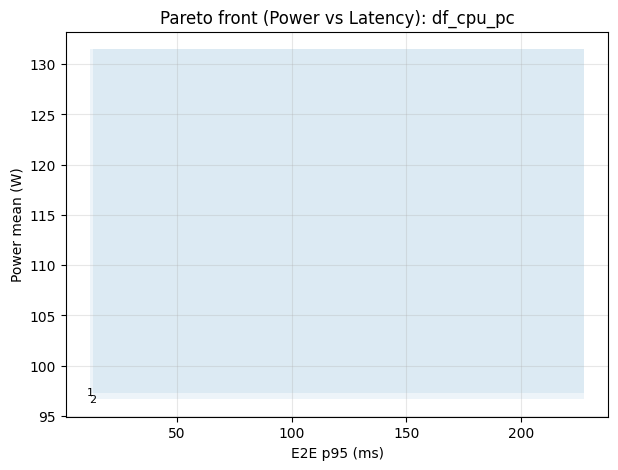

,Pareto_id_power,Label,mAP50,Latency_p95,Size_MB,Power_W_Mean,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
0,1,n 256 fp32 ORT ALL,0.4589,12.236667,10.07,97.333333,866.0,12459.790000,NaN
1,2,n 256 fp16 ORT ALL,0.4590,13.156667,5.07,96.666667,866.0,12397.683333,NaN


df_cpu_pc - objectif 1 (power mean asc, p95 asc)


,Hardware,Model_Name,Latency_p95,Power_W_Mean,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
30,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11n_256_fp16,13.156667,96.666667,0.4590,5.07,2.0,866.00,12397.683333,NaN
44,CPU_ORT_PC_x86_64_SEQ_DISABLE,yolo11n_416_fp16,27.076667,96.833333,0.5801,5.09,NaN,888.44,12171.700000,NaN
31,CPU_ORT_PC_x86_64_SEQ_BASIC,yolo11n_256_fp16,15.386667,97.000000,0.4590,5.07,NaN,867.19,12354.976667,NaN


df_cpu_pc - objectif 2 (p95 asc, power mean asc)


,Hardware,Model_Name,Latency_p95,Power_W_Mean,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
33,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11n_256_fp32,12.236667,97.333333,0.4589,10.07,1.0,866.00,12459.790000,NaN
35,CPU_ORT_PC_x86_64_SEQ_DISABLE,yolo11n_256_fp32,12.843333,97.333333,0.4589,10.07,NaN,867.19,12482.013333,NaN
30,CPU_ORT_PC_x86_64_SEQ_ALL,yolo11n_256_fp16,13.156667,96.666667,0.4590,5.07,2.0,866.00,12397.683333,NaN


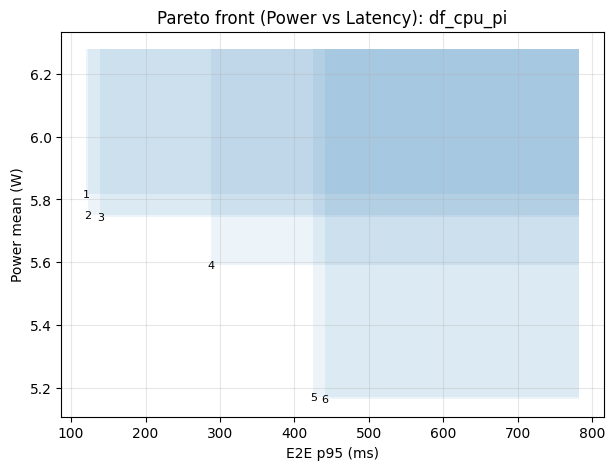

,Pareto_id_power,Label,mAP50,Latency_p95,Size_MB,Power_W_Mean,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
0,1,n 256 fp32 ORT ALL,0.4589,119.993333,10.07,5.816667,375.43,559.293333,NaN
1,2,n 256 fp16 ORT ALL,0.4590,122.586667,5.07,5.750000,375.43,556.080000,NaN
2,3,n 256 fp16 ORT BASIC,0.4590,139.350000,5.07,5.743333,375.43,556.100000,NaN
3,4,n 416 fp16 ORT ALL,0.5801,288.016667,5.09,5.590000,375.42,555.616667,NaN
4,5,n 512 fp16 ORT ALL,0.6376,425.493333,5.11,5.170000,396.79,577.143333,NaN
5,6,n 512 fp16 ORT BASIC,0.6376,440.400000,5.11,5.163333,404.66,585.746667,NaN


df_cpu_pi - objectif 1 (power mean asc, p95 asc)


,Hardware,Model_Name,Latency_p95,Power_W_Mean,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
19,CPU_ORT_PI4_SEQ_BASIC,yolo11n_512_fp16,440.400000,5.163333,0.6376,5.11,6.0,404.66,585.746667,NaN
18,CPU_ORT_PI4_SEQ_ALL,yolo11n_512_fp16,425.493333,5.170000,0.6376,5.11,5.0,396.79,577.143333,NaN
20,CPU_ORT_PI4_SEQ_DISABLE,yolo11n_512_fp16,439.583333,5.226667,0.6376,5.11,NaN,404.67,587.310000,NaN


df_cpu_pi - objectif 2 (p95 asc, power mean asc)


,Hardware,Model_Name,Latency_p95,Power_W_Mean,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
3,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp32,119.993333,5.816667,0.4589,10.07,1.0,375.43,559.293333,NaN
0,CPU_ORT_PI4_SEQ_ALL,yolo11n_256_fp16,122.586667,5.750000,0.4590,5.07,2.0,375.43,556.080000,NaN
5,CPU_ORT_PI4_SEQ_DISABLE,yolo11n_256_fp32,127.733333,5.793333,0.4589,10.07,NaN,375.43,559.420000,NaN


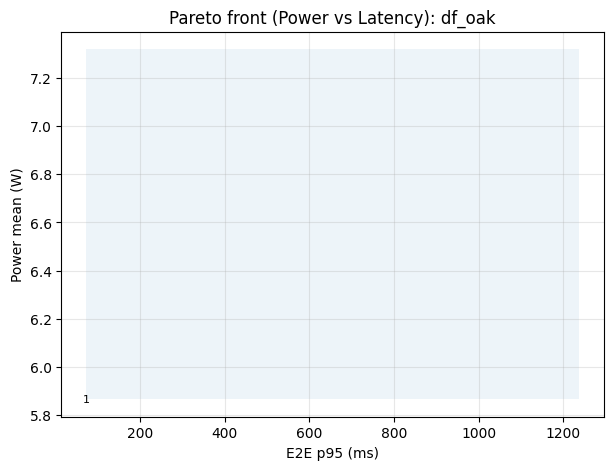

,Pareto_id_power,Label,mAP50,Latency_p95,Size_MB,Power_W_Mean,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
0,1,n 256 fp16 OAK S6,0.4567,72.616667,5.54,5.866667,386.276667,559.64,NaN


df_oak - objectif 1 (power mean asc, p95 asc)


,Hardware,Model_Name,Latency_p95,Power_W_Mean,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
27,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11n_256_fp16_6shave,72.616667,5.866667,0.4567,5.54,1.0,386.276667,559.640000,NaN
26,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_5,yolo11n_256_fp16_5shave,74.036667,5.933333,0.4567,5.54,NaN,386.083333,557.516667,NaN
59,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_8,yolo11s_320_fp16_8shave,159.790000,5.966667,0.6470,19.00,NaN,315.353333,514.270000,NaN


df_oak - objectif 2 (p95 asc, power mean asc)


,Hardware,Model_Name,Latency_p95,Power_W_Mean,mAP50,Size_MB,Pareto_id_power,RAM_RSS_MB_Mean,RAM_Sys_Used_MB_Mean,VRAM_Used_MB_Mean
27,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_6,yolo11n_256_fp16_6shave,72.616667,5.866667,0.4567,5.54,1.0,386.276667,559.640000,NaN
25,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_4,yolo11n_256_fp16_4shave,72.666667,6.066667,0.4567,5.54,NaN,387.070000,558.680000,NaN
28,OAK_MyriadX_HOST_PI4_aarch64_SHAVES_7,yolo11n_256_fp16_7shave,72.766667,6.066667,0.4567,5.54,NaN,386.076667,561.406667,NaN


In [7]:
# Pareto: Latency p95 (min) vs Power mean (min)
import numpy as np
import matplotlib.pyplot as plt

def pareto_min_min(df: pd.DataFrame, x_col: str, y_col: str) -> pd.DataFrame:
    work = df.copy()
    work = work[(work["Phase"] == "run") & work[x_col].notna() & work[y_col].notna()]
    if work.empty:
        return work

    vals = work[[x_col, y_col]].values
    is_pareto = np.ones(len(work), dtype=bool)

    for i, (x, y) in enumerate(vals):
        if not is_pareto[i]:
            continue
        dominated = (vals[:, 0] <= x) & (vals[:, 1] <= y) & (
            (vals[:, 0] < x) | (vals[:, 1] < y)
        )
        if dominated.any():
            is_pareto[i] = False

    return work[is_pareto].sort_values([x_col, y_col], ascending=[True, True])


all_dfs_power = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Latency_p95", "Power_W_Mean"}.issubset(val.columns)
}

pareto_power_dfs = {
    name: pareto_min_min(val, "Latency_p95", "Power_W_Mean")
    for name, val in all_dfs_power.items()
}

for name, pdf in pareto_power_dfs.items():
    if pdf.empty:
        print(f"{name}: no rows")
        continue

    pdf = pdf.reset_index(drop=True)
    pdf["Pareto_id_power"] = np.arange(1, len(pdf) + 1)
    pdf["Label"] = pdf.apply(short_label, axis=1)

    # Reference point for hypervolume shading (worse corner)
    work = all_dfs_power[name]
    work = work[(work["Phase"] == "run") & work["Latency_p95"].notna() & work["Power_W_Mean"].notna()]
    ref_x = work["Latency_p95"].max() * 1.05
    ref_y = work["Power_W_Mean"].max() * 1.05

    fig, ax = plt.subplots(figsize=(7, 5))

    # Hypervolume (dominated region) shading
    for _, row in pdf.iterrows():
        ax.fill_between(
            [row["Latency_p95"], ref_x],
            row["Power_W_Mean"],
            ref_y,
            color="tab:blue",
            alpha=0.08,
            linewidth=0,
        )

    # Points + numeric labels
    for _, row in pdf.iterrows():
        ax.text(
            row["Latency_p95"],
            row["Power_W_Mean"],
            str(int(row["Pareto_id_power"])),
            fontsize=8,
            ha="center",
            va="center",
        )

    ax.set_xlabel("E2E p95 (ms)")
    ax.set_ylabel("Power mean (W)")
    ax.set_title(f"Pareto front (Power vs Latency): {name}")
    ax.grid(True, alpha=0.3)
    plt.show()

    # Mapping table
    pareto_cols = [
        "Pareto_id_power",
        "Label",
        "mAP50",
        "Latency_p95",
        "Size_MB",
        "Power_W_Mean",
        "RAM_RSS_MB_Mean",
        "RAM_Sys_Used_MB_Mean",
        "VRAM_Used_MB_Mean",
    ]
    display(pdf[[c for c in pareto_cols if c in pdf.columns]])

    # Objective tables
    run = work.copy()
    pareto_map = pdf[["Hardware", "Model_Name", "Latency_p95", "Power_W_Mean", "Pareto_id_power"]]
    run = run.merge(
        pareto_map,
        on=["Hardware", "Model_Name", "Latency_p95", "Power_W_Mean"],
        how="left",
    )

    cols = [
        "Hardware",
        "Model_Name",
        "Latency_p95",
        "Power_W_Mean",
        "mAP50",
        "Size_MB",
        "Pareto_id_power",
        "RAM_RSS_MB_Mean",
        "RAM_Sys_Used_MB_Mean",
        "VRAM_Used_MB_Mean",
    ]

    obj1 = run.sort_values(["Power_W_Mean", "Latency_p95"], ascending=[True, True]).head(3)
    obj2 = run.sort_values(["Latency_p95", "Power_W_Mean"], ascending=[True, True]).head(3)

    print(f"{name} - objectif 1 (power mean asc, p95 asc)")
    display(obj1[cols])
    print(f"{name} - objectif 2 (p95 asc, power mean asc)")
    display(obj2[cols])


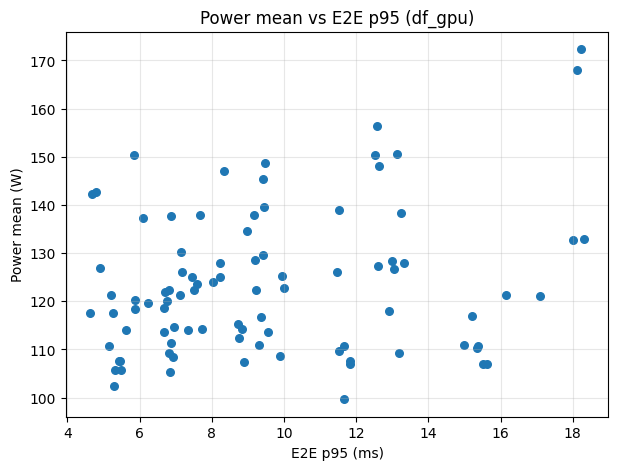

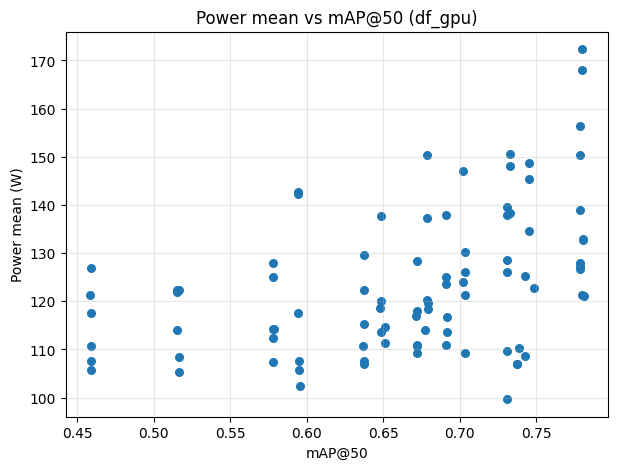

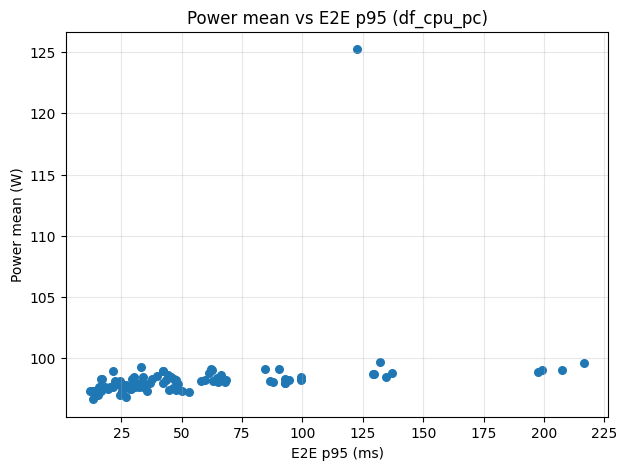

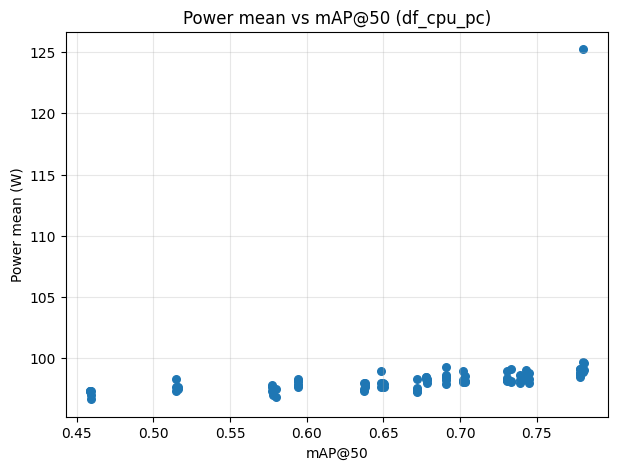

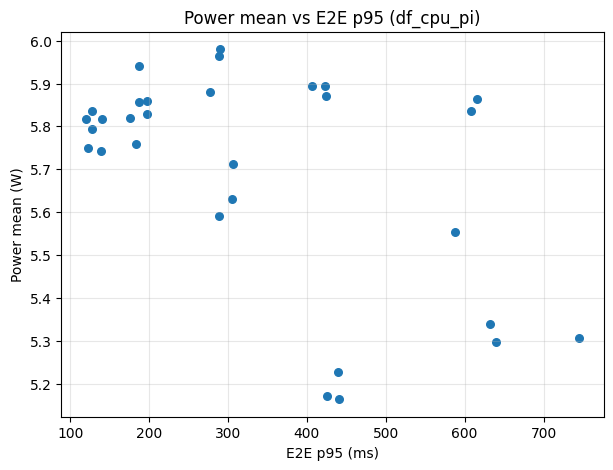

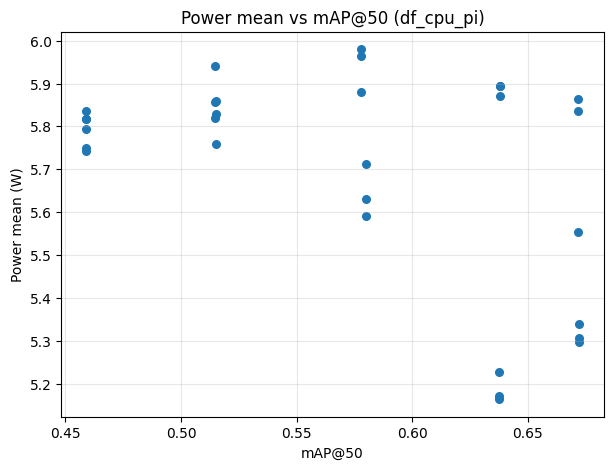

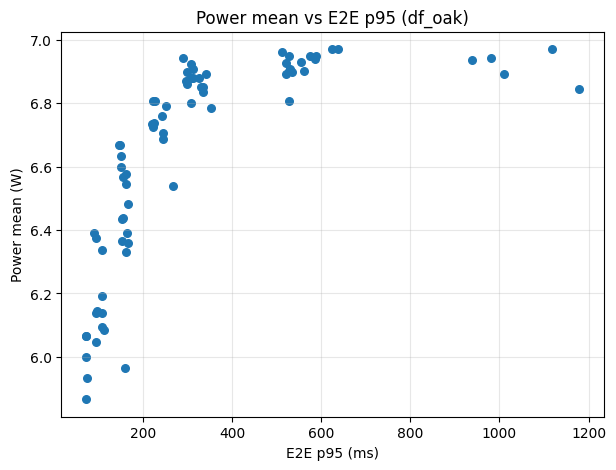

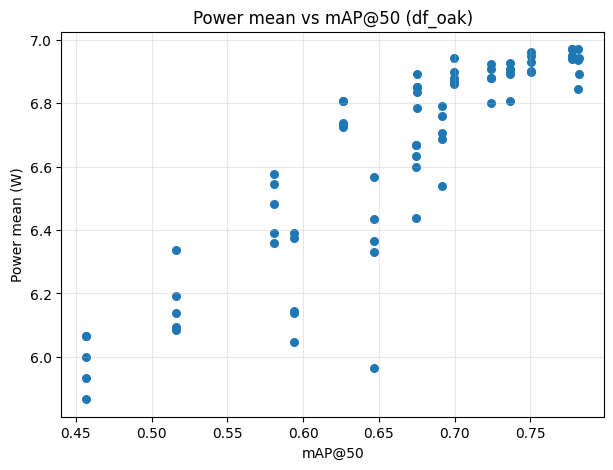

In [8]:
# Line charts per hardware: Power mean vs p95, and Power mean vs mAP50
import matplotlib.pyplot as plt

dfs_line = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Latency_p95", "Power_W_Mean", "mAP50"}.issubset(val.columns)
}

def _prepare(df: pd.DataFrame, x_col: str) -> pd.DataFrame:
    work = df[(df["Phase"] == "run") & df[x_col].notna() & df["Power_W_Mean"].notna()].copy()
    return work.sort_values(x_col)

for name, d in dfs_line.items():
    w = _prepare(d, "Latency_p95")
    if w.empty:
        continue
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(w["Latency_p95"], w["Power_W_Mean"], label=name, s=30)
    ax.set_xlabel("E2E p95 (ms)")
    ax.set_ylabel("Power mean (W)")
    ax.set_title(f"Power mean vs E2E p95 ({name})")
    ax.grid(True, alpha=0.3)
    plt.show()

    w = _prepare(d, "mAP50")
    if w.empty:
        continue
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(w["mAP50"], w["Power_W_Mean"], label=name, s=30)
    ax.set_xlabel("mAP@50")
    ax.set_ylabel("Power mean (W)")
    ax.set_title(f"Power mean vs mAP@50 ({name})")
    ax.grid(True, alpha=0.3)
    plt.show()


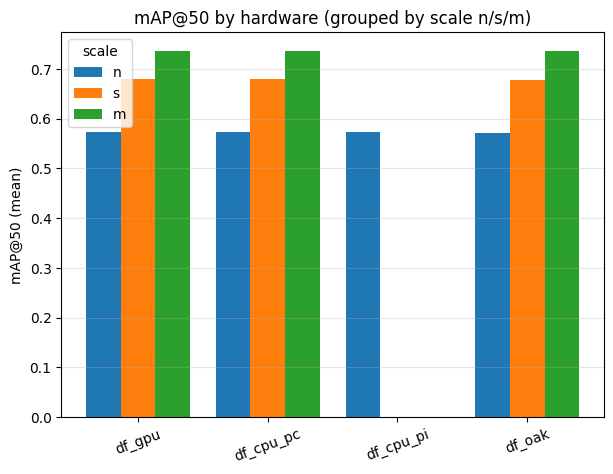

In [9]:
# Grouped bar: mAP@50 by hardware and model scale (n/s/m)
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _extract_scale(name: str) -> str | None:
    match = re.search(r"yolo11([nsm])_", str(name))
    return match.group(1) if match else None

dfs_bar = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and {"Phase", "Model_Name", "mAP50"}.issubset(val.columns)
}

rows = []
for name, d in dfs_bar.items():
    w = d[d["Phase"] == "run"].copy()
    if w.empty:
        continue
    w["scale"] = w["Model_Name"].apply(_extract_scale)
    w = w[w["scale"].notna()]
    if w.empty:
        continue
    w["mAP50"] = pd.to_numeric(w["mAP50"], errors="coerce")
    g = w.groupby("scale")["mAP50"].mean().reset_index()
    for _, row in g.iterrows():
        rows.append({"hardware": name, "scale": row["scale"], "mAP50": row["mAP50"]})

if rows:
    df_plot = pd.DataFrame(rows)
    scales = [s for s in ["n", "s", "m"] if s in df_plot["scale"].unique()]
    hardwares = list(df_plot["hardware"].unique())

    width = 0.8 / max(len(scales), 1)
    x = np.arange(len(hardwares))

    fig, ax = plt.subplots(figsize=(7, 5))
    for i, s in enumerate(scales):
        vals = []
        for hw in hardwares:
            v = df_plot[(df_plot["hardware"] == hw) & (df_plot["scale"] == s)]["mAP50"]
            vals.append(float(v.iloc[0]) if len(v) else 0.0)
        ax.bar(x + i * width, vals, width=width, label=s)

    ax.set_ylabel("mAP@50 (mean)")
    ax.set_title("mAP@50 by hardware (grouped by scale n/s/m)")
    ax.set_xticks(x + width * (len(scales) - 1) / 2)
    ax.set_xticklabels(hardwares, rotation=20)
    ax.legend(title="scale")
    ax.grid(True, axis="y", alpha=0.3)
    plt.show()
else:
    print("No data for grouped mAP50 chart.")


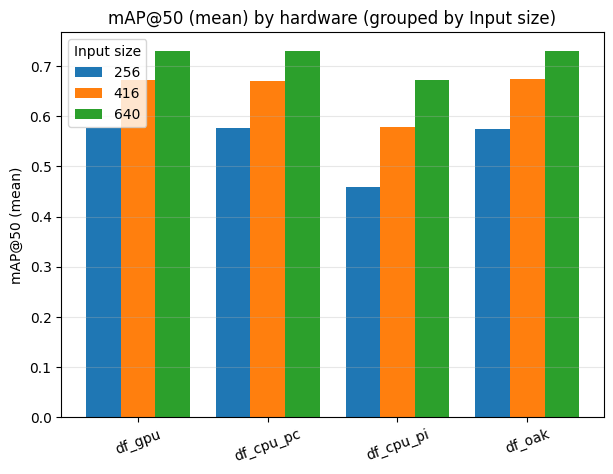

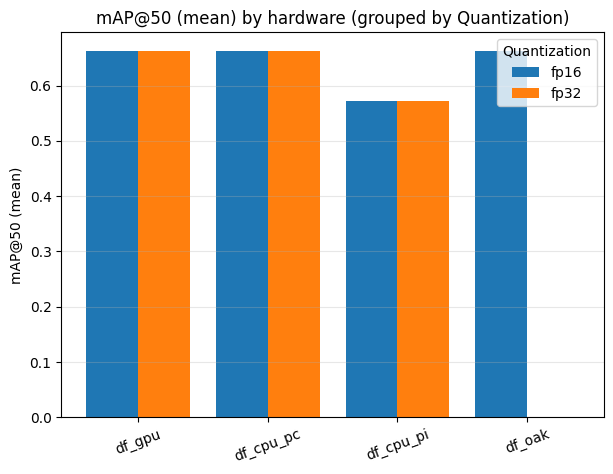

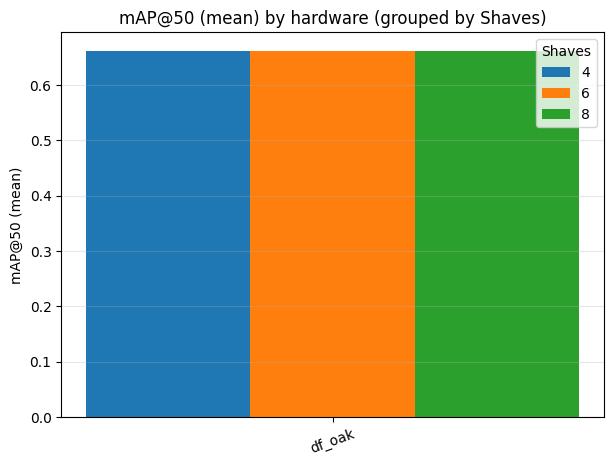

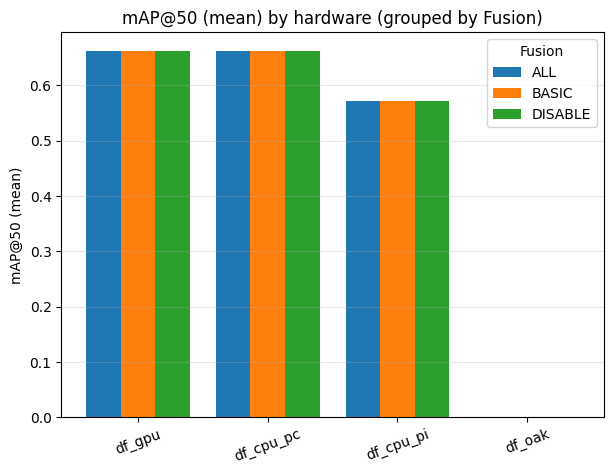

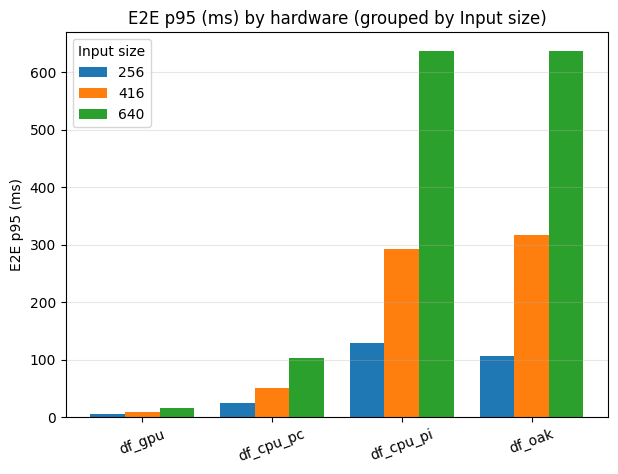

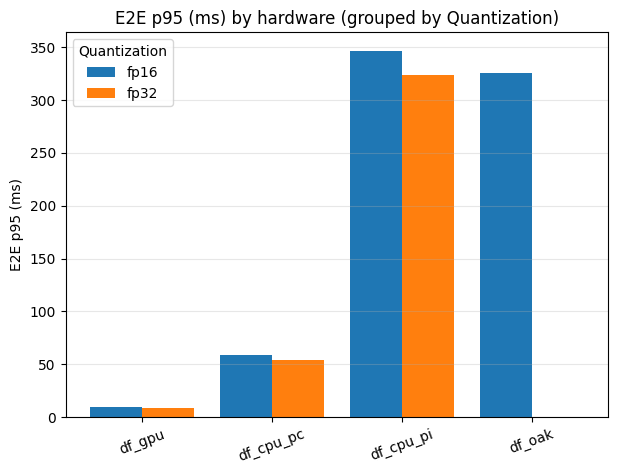

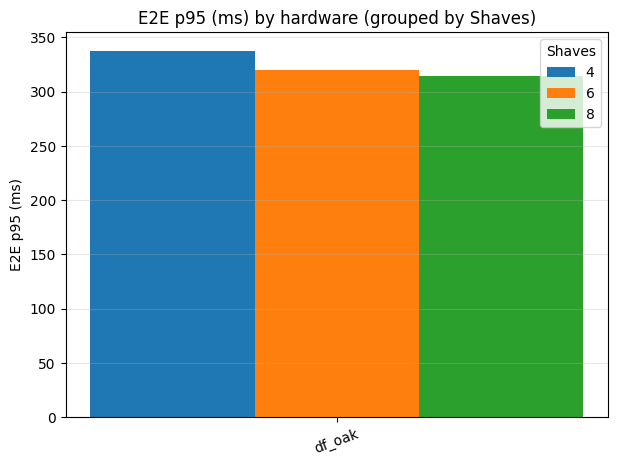

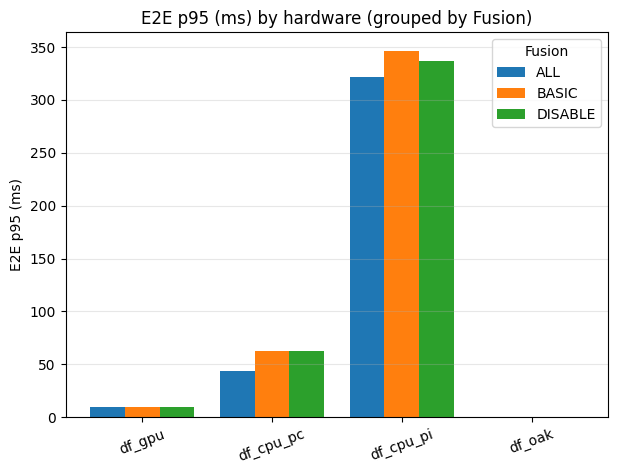

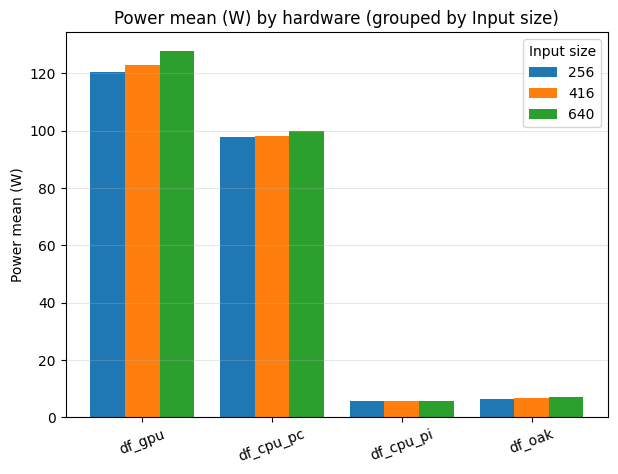

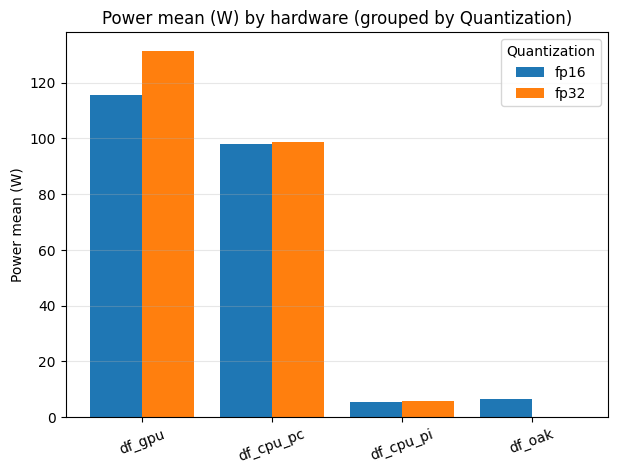

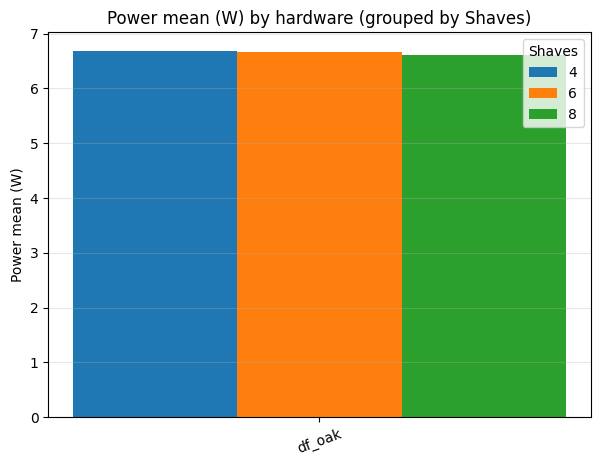

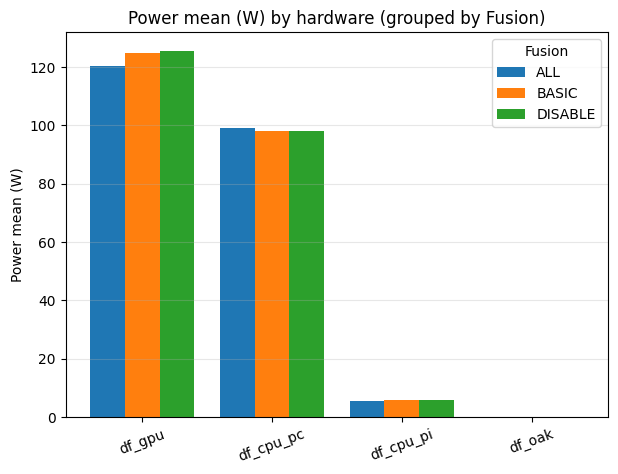

In [10]:
# Grouped bar charts: metrics vs categories (resolution, quant, shaves, fusion)
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dfs_grouped = {
    name: val
    for name, val in globals().items()
    if name.startswith("df_")
    and isinstance(val, pd.DataFrame)
    and not val.empty
    and "Phase" in val.columns
}

def _get_imgsz(row: pd.Series) -> int | None:
    v = row.get("ImgSz", None)
    if pd.notna(v):
        try:
            return int(v)
        except (TypeError, ValueError):
            pass
    match = re.search(r"yolo11[nsm]_(\d+)_", str(row.get("Model_Name", "")))
    return int(match.group(1)) if match else None

def _get_quant(row: pd.Series) -> str | None:
    match = re.search(r"_fp(16|32)", str(row.get("Model_Name", "")))
    return f"fp{match.group(1)}" if match else None

def _get_shaves(row: pd.Series) -> int | None:
    match = re.search(r"_SHAVES_(\d+)", str(row.get("Hardware", "")))
    if match:
        return int(match.group(1))
    match = re.search(r"_(\d+)shave", str(row.get("Model_Name", "")))
    return int(match.group(1)) if match else None

def _get_fusion(row: pd.Series) -> str | None:
    hardware = str(row.get("Hardware", ""))
    match = re.search(r"_(ALL|BASIC|DISABLE)\b", hardware)
    if match:
        return match.group(1)
    ort = str(row.get("ORT_Level_Requested", ""))
    if ort and ort != "N/A":
        return ort.split("->")[-1].upper()
    return None

def _pick_three(values):
    vals = sorted(set(values))
    if len(vals) <= 3:
        return vals
    return [vals[0], vals[len(vals) // 2], vals[-1]]

def _grouped_chart(metric_col, metric_label, cat_fn, cat_label, cat_values=None, numeric=False):
    rows = []
    for name, d in dfs_grouped.items():
        w = d[d["Phase"] == "run"].copy()
        if metric_col not in w.columns:
            continue
        w[metric_col] = pd.to_numeric(w[metric_col], errors="coerce")
        w["cat"] = w.apply(cat_fn, axis=1)
        w = w[w["cat"].notna()]
        if w.empty:
            continue
        for _, row in w.iterrows():
            rows.append({"hardware": name, "cat": row["cat"], metric_col: row[metric_col]})

    if not rows:
        print(f"No data for {metric_label} by {cat_label}.")
        return

    df_plot = pd.DataFrame(rows)
    if numeric:
        df_plot["cat"] = pd.to_numeric(df_plot["cat"], errors="coerce")
    categories = cat_values if cat_values is not None else _pick_three(df_plot["cat"].dropna().tolist())
    categories = [c for c in categories if c in df_plot["cat"].unique()]
    if not categories:
        print(f"No categories for {cat_label}.")
        return

    hardwares = list(df_plot["hardware"].unique())
    width = 0.8 / max(len(categories), 1)
    x = np.arange(len(hardwares))

    fig, ax = plt.subplots(figsize=(7, 5))
    for i, c in enumerate(categories):
        vals = []
        for hw in hardwares:
            vals_hw = df_plot[(df_plot["hardware"] == hw) & (df_plot["cat"] == c)][metric_col]
            vals.append(float(vals_hw.mean()) if len(vals_hw) else 0.0)
        ax.bar(x + i * width, vals, width=width, label=str(c))

    ax.set_ylabel(metric_label)
    ax.set_title(f"{metric_label} by hardware (grouped by {cat_label})")
    ax.set_xticks(x + width * (len(categories) - 1) / 2)
    ax.set_xticklabels(hardwares, rotation=20)
    ax.legend(title=cat_label)
    ax.grid(True, axis="y", alpha=0.3)
    plt.show()

metrics = [
    ("mAP50", "mAP@50 (mean)"),
    ("Latency_p95", "E2E p95 (ms)"),
    ("Power_W_Mean", "Power mean (W)"),
]

categories = [
    ("Input size", _get_imgsz, None, True),
    ("Quantization", _get_quant, ["fp16", "fp32"], False),
    ("Shaves", _get_shaves, None, True),
    ("Fusion", _get_fusion, ["ALL", "BASIC", "DISABLE"], False),
]

for metric_col, metric_label in metrics:
    for cat_label, cat_fn, cat_vals, numeric in categories:
        _grouped_chart(metric_col, metric_label, cat_fn, cat_label, cat_vals, numeric)
